# Face Mask Detection using YOLOv8
## Overview
In today's dynamic environments, ensuring public safety and health protocols is paramount. This project leverages advanced deep learning techniques, specifically the YOLOv8 architecture, to develop a robust model for face mask detection. The model accurately identifies instances of individuals wearing masks, not wearing masks, and wearing masks improperly in real-time scenarios. This technology serves as a proactive measure to enforce compliance with mask-wearing guidelines and enhance safety across various settings.

## Problem Statement
The consistent use of face masks is crucial for preventing the spread of airborne diseases and maintaining public health. Manual monitoring of mask compliance is resource-intensive and often subjective, necessitating automated solutions that can reliably and accurately detect mask-wearing behaviors in real-time.

In [1]:
import zipfile
import os

In [2]:
if os.path.exists('./face-mask-detection.zip'):
    print("Dataset already exist")
else:
    !kaggle datasets download -d andrewmvd/face-mask-detection

Dataset already exist


In [3]:
if os.path.exists('./face-mask-detection'):
    print("Folder named face-mask-detection already exist, either delete that folder or skip past this step")
else:
    folder = "./face-mask-detection"
    with zipfile.ZipFile('./face-mask-detection.zip','r') as zip_ref:
        zip_ref.extractall(folder)

Folder named face-mask-detection already exist, either delete that folder or skip past this step


In [4]:
import pandas as pd
import numpy as np 
import xml.etree.ElementTree as et
from IPython.display import clear_output
import random
import shutil
import yaml
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
os.environ['WANDB_DISABLED'] = 'true'
random.seed(42)
os.makedirs('outputs',exist_ok=True)
%matplotlib inline

# Dataset and Annotations

## Dataset
The dataset used for this project is sourced from the [Face Mask Detection dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection) on Kaggle. This dataset comprises a diverse collection of annotated images depicting individuals in various settings, including indoor and outdoor environments. Each image is annotated to indicate instances where individuals are wearing masks, not wearing masks, or wearing masks improperly.

## Annotations Processing
### 1. Data Preprocessing:

The initial step involves parsing XML annotation files provided with each image in the dataset. These XML files contain detailed annotations specifying the location and class label of each detected instance within the image.
### 2. Dataframe Creation:

The annotations from XML files are processed to create a structured dataframe. This dataframe includes entries for each image, listing the filename and associated instances of masks detected. Each instance is characterized by its bounding box coordinates and class label (wearing mask, not wearing mask, or not wearing mask properly).
### 3. YOLOv8-Compatible Annotations:

To facilitate training using YOLOv8, the bounding box coordinates are transformed into YOLO format. This involves converting the coordinates to represent the center of the bounding box relative to the image dimensions, and normalizing these coordinates to range between 0 and 1. Class labels are encoded numerically based on the YOLO model's requirements.
### 4. Folder Structure
The dataset is organized into a YOLOv8-compatible folder structure:

* **Images:** Located in `dataset/images`, divided into `train` and `validation` subfolders.
* **Labels:** Located in `dataset/labels`, similarly divided into `train` and `validation` subfolders.
### 5. Config.yaml Creation
Upon preprocessing the dataset and organizing annotations, a config.yaml file is generated. This configuration file outlines the model settings, including dataset paths and other parameters essential for training the YOLOv8 model.

In [5]:
img_path = './face-mask-detection/images/'
annot_path = './face-mask-detection/annotations/'

In [6]:
# Extract information from xml files
def get_parsed_xml_data(xml_path=None):
    if not xml_path:
        raise AttributeError("Please Provide xml_path. xml_path cannot be none.")
    
    root = et.parse(xml_path).getroot()
    name = root.find('filename').text
    width , height = map(int,[root.find('size').find('width').text ,root.find('size').find('height').text])
    instances = []
    for obj in root.findall('object'):
        bnd_box = obj.find('bndbox')
        class_ = obj.find('name').text 
        xmin,ymin,xmax,ymax = bnd_box.find('xmin').text,bnd_box.find('ymin').text, bnd_box.find('xmax').text,bnd_box.find('ymax').text
        instances.append((class_,[xmin,ymin,xmax,ymax]))
    return pd.Series([name,width,height,instances],index=['file','width','height','instances'])

In [7]:
df = pd.DataFrame(columns=['file','width','height','instances'])
for i in os.listdir('./face-mask-detection/annotations'):
    path = os.path.join(annot_path,i)
    display(path)
    parsed_xml = get_parsed_xml_data(path)
    df = pd.concat([df,parsed_xml.to_frame().T],ignore_index=True)
    clear_output(True)
count = 0
df.head()

,file,width,height,instances
0,maksssksksss0.png,512,366,"[(without_mask, [79, 105, 109, 142]), (with_ma..."
1,maksssksksss1.png,400,156,"[(with_mask, [321, 34, 354, 69]), (with_mask, ..."
2,maksssksksss10.png,301,400,"[(with_mask, [98, 267, 194, 383])]"
3,maksssksksss100.png,400,226,"[(with_mask, [189, 30, 245, 88]), (with_mask, ..."
4,maksssksksss101.png,301,400,"[(with_mask, [48, 294, 164, 400])]"


In [8]:
# split the tuple and returns a pd.Series / used for spliting single column to multiple column
def split_data(row):
    class_ , bnd = row
    return pd.Series([class_]+bnd)

In [9]:
# create multiple entries of single image each corresponding to single bounding box
if count == 0:
    df = df.explode(column='instances')
    count+=1
df[['class','xmin','ymin','xmax','ymax']] = df['instances'].apply(split_data)
df.head()

,file,width,height,instances,class,xmin,ymin,xmax,ymax
0,maksssksksss0.png,512,366,"(without_mask, [79, 105, 109, 142])",without_mask,79,105,109,142
0,maksssksksss0.png,512,366,"(with_mask, [185, 100, 226, 144])",with_mask,185,100,226,144
0,maksssksksss0.png,512,366,"(without_mask, [325, 90, 360, 141])",without_mask,325,90,360,141
1,maksssksksss1.png,400,156,"(with_mask, [321, 34, 354, 69])",with_mask,321,34,354,69
1,maksssksksss1.png,400,156,"(with_mask, [224, 38, 261, 73])",with_mask,224,38,261,73


In [10]:
# drop unnecessary columns
df.drop(columns=['instances'],inplace=True)
df.head()

,file,width,height,class,xmin,ymin,xmax,ymax
0,maksssksksss0.png,512,366,without_mask,79,105,109,142
0,maksssksksss0.png,512,366,with_mask,185,100,226,144
0,maksssksksss0.png,512,366,without_mask,325,90,360,141
1,maksssksksss1.png,400,156,with_mask,321,34,354,69
1,maksssksksss1.png,400,156,with_mask,224,38,261,73


In [11]:
# type casting to int
df[['width','height','xmin','ymin','xmax','ymax']] = df[['width','height','xmin','ymin','xmax','ymax']].astype(int)

In [12]:
# get the center of the bounding box and its width and height
def get_normalized_bounding_boxes(row):
    x_center = (row['xmax'] + row['xmin'])/(row['width']*2)
    y_center = (row['ymax'] + row['ymin'])/(row['height']*2)
    bb_w = (row['xmax']-row['xmin'])/row['width']
    bb_h = (row['ymax'] - row['ymin'])/row['height']
    return pd.Series([x_center,y_center,bb_w,bb_h])

In [13]:
df[['xcenter','ycenter','bb_width','bb_height']] = df.apply(get_normalized_bounding_boxes,axis=1)
df.head()

,file,width,height,class,xmin,ymin,xmax,ymax,xcenter,ycenter,bb_width,bb_height
0,maksssksksss0.png,512,366,without_mask,79,105,109,142,0.183594,0.337432,0.058594,0.101093
0,maksssksksss0.png,512,366,with_mask,185,100,226,144,0.401367,0.333333,0.080078,0.120219
0,maksssksksss0.png,512,366,without_mask,325,90,360,141,0.668945,0.315574,0.068359,0.139344
1,maksssksksss1.png,400,156,with_mask,321,34,354,69,0.843750,0.330128,0.082500,0.224359
1,maksssksksss1.png,400,156,with_mask,224,38,261,73,0.606250,0.355769,0.092500,0.224359


In [14]:
# class encoding and inversion maps
class_map = {x:y for (x,y) in zip(df['class'].unique(),range(df['class'].nunique()))}
inverse_map = {x:y for (x,y) in zip(class_map.values(),class_map.keys())}
class_map , inverse_map

({'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2},
 {0: 'without_mask', 1: 'with_mask', 2: 'mask_weared_incorrect'})

In [15]:
df['enc_class'] = df['class'].apply(lambda x:class_map[x])
df.head()

,file,width,height,class,xmin,ymin,xmax,ymax,xcenter,ycenter,bb_width,bb_height,enc_class
0,maksssksksss0.png,512,366,without_mask,79,105,109,142,0.183594,0.337432,0.058594,0.101093,0
0,maksssksksss0.png,512,366,with_mask,185,100,226,144,0.401367,0.333333,0.080078,0.120219,1
0,maksssksksss0.png,512,366,without_mask,325,90,360,141,0.668945,0.315574,0.068359,0.139344,0
1,maksssksksss1.png,400,156,with_mask,321,34,354,69,0.843750,0.330128,0.082500,0.224359,1
1,maksssksksss1.png,400,156,with_mask,224,38,261,73,0.606250,0.355769,0.092500,0.224359,1


In [16]:
df.to_csv('./outputs/processed_data.csv',index=False) # save the csv so it can be used directly next time

**Convert Dataset to yolo format**

In [17]:
imp_paths = ['dataset','dataset/images','dataset/labels','dataset/images/train','dataset/images/validation',
             'dataset/labels/train','dataset/labels/validation']

for i in imp_paths:
    if not os.path.exists(i):
        print(f'Creating {i}')
        os.makedirs(i)
    else:
        print(f"{i} already exists")

dataset already exists
dataset/images already exists
dataset/labels already exists
dataset/images/train already exists
dataset/images/validation already exists
dataset/labels/train already exists
dataset/labels/validation already exists


In [18]:
train_img = './dataset/images/train'
train_label = './dataset/labels/train'
val_img = './dataset/images/validation'
val_label = './dataset/labels/validation'

In [19]:
# shuffles the images and splits them into train & test
imgs = os.listdir('./face-mask-detection/images')
random.shuffle(imgs)
val_split_size = int(len(imgs) * 0.1)
train = imgs[:len(imgs)-val_split_size]
val = imgs[len(imgs)-val_split_size:]

In [20]:
#create a train split from the images
if len(os.listdir(train_img)) == 0:
    for i in train:
        temp = df[df['file']==i][['file','enc_class','xcenter','ycenter','bb_width','bb_height']]
        name = temp['file'].unique()[0]
        shutil.copy(os.path.join(img_path,name),os.path.join(train_img,name))
        with open(os.path.join(train_label,f"{name.split('.')[0]}.txt"),'w') as f:
            for idx,row  in temp.iterrows():
                tp = " ".join(map(str,[int(row['enc_class']),row['xcenter'],row['ycenter'],row['bb_width'],row['bb_height']]))
                f.write(f"{tp}\n")
#create a validation split from the images
if len(os.listdir(val_img)) == 0:
    for i in val:
        temp = df[df['file']==i][['file','enc_class','xcenter','ycenter','bb_width','bb_height']]
        name = temp['file'].unique()[0]
        shutil.copy(os.path.join(img_path,name),os.path.join(val_img,name))
        with open(os.path.join(val_label,f"{name.split('.')[0]}.txt"),'w') as f:
            for idx,row  in temp.iterrows():
                tp = " ".join(map(str,[int(row['enc_class']),row['xcenter'],row['ycenter'],row['bb_width'],row['bb_height']]))
                f.write(f"{tp}\n")
    

In [21]:
# create a config yaml file for yolo model to train
data = {'path': os.path.abspath('dataset'),
       'train':os.path.abspath('dataset/images/train'),
       'val':os.path.abspath('dataset/images/validation'),
       'nc':len(class_map),
       'names':inverse_map}
with open('./config.yaml', 'w') as file:
    yaml.dump(data, file)

# Model Architecture
For this project, the YOLOv8l (YOLO Version 8 Large) model from Ultralytics is utilized. YOLOv8l is a state-of-the-art object detection model known for its balance of speed and accuracy, making it ideal for real-time applications. The architecture builds upon previous YOLO versions, incorporating enhancements in network design, such as more efficient convolutional layers and optimized anchor boxes, to improve detection performance.

## Pretrained Model
Instead of training the model from scratch, a pretrained YOLOv8l model is employed to leverage transfer learning, significantly reducing the computational resources and time required for training. The pretrained model, sourced from [Kaggle](https://www.kaggle.com/models/shivam2111/yolov8l-mask-detection/PyTorch/yolov8l-v1.0/1/), has been fine-tuned specifically for the face mask detection task. This pretrained model has already learned to identify the three classes of interest:

* Wearing mask
* Not wearing mask
* Not wearing mask properly
## Advantages of Using Pretrained Model
* **Time Efficiency:** Utilizing a pretrained model drastically reduces the training time required, as the model has already been exposed to a large and diverse dataset.
* **Performance Boost:** Pretrained models benefit from the knowledge gained during initial training on extensive datasets, enhancing their performance on specific tasks with less data.
* **Resource Optimization:** Training deep learning models from scratch demands substantial computational resources. Using a pretrained model makes it feasible to deploy powerful models even on limited hardware.

In [22]:
import ultralytics 
from ultralytics import YOLO
import kagglehub

In [23]:
kpath = None
model = None
try:
    # Download latest version
    kpath = kagglehub.model_download("shivam2111/yolov8l-mask-detection/pyTorch/yolov8l-v1.0")
    print("Path to model files:", kpath)
except Exception as e:
    raise e

Path to model files: C:\Users\shiva\.cache\kagglehub\models\shivam2111\yolov8l-mask-detection\pyTorch\yolov8l-v1.0\1


In [24]:
if kpath:
    print(f"Using Kaggle Model at {kpath}")
    model = YOLO(kpath+'/yolov8l.pt')
else:
    print("Using Ultralytics model and training")
    model = YOLO('yolov8l.pt')
    hist = model.train(data='config.yaml',epochs=10000)

Using Kaggle Model at C:\Users\shiva\.cache\kagglehub\models\shivam2111\yolov8l-mask-detection\pyTorch\yolov8l-v1.0\1


# Evaluation

## Evaluation Metrics
Model performance is assessed using rigorous evaluation metrics including precision, recall, and mean average precision (mAP). These metrics provide quantitative insights into the model's ability to accurately detect masks across different classes and environmental settings. Evaluation on validation datasets ensures that the model maintains high accuracy and reliability in real-world applications.

In [25]:
metrics = model.val(data='config.yaml',verbose=False)
eval_data = {'metrics':['mAP(50-95)','mAP(50)','mAP(75)'] , 'score':[metrics.box.map,metrics.box.map50,metrics.box.map75]}
mAP_over_cls = {'class':['with_mask','mask_weared_incorrectly','without_mask'],'mAP':metrics.box.maps,'precision':metrics.box.p,'recall':metrics.box.r}
eval_df = pd.DataFrame(eval_data)
mAP_cls = pd.DataFrame(mAP_over_cls)

Ultralytics YOLOv8.2.42  Python-3.10.9 torch-2.2.2 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning E:\YOUTUBE\Computer Vision\Face Mask Detection\FMD-GIT\dataset\labels\validation.cache... 85 images, 0 ba
C:\Users\shiva\.conda\envs\pytorch\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<0


                   all         85        315      0.159      0.142     0.0859     0.0774
Speed: 1.4ms preprocess, 50.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs\detect\val3


<Axes: xlabel='metrics'>

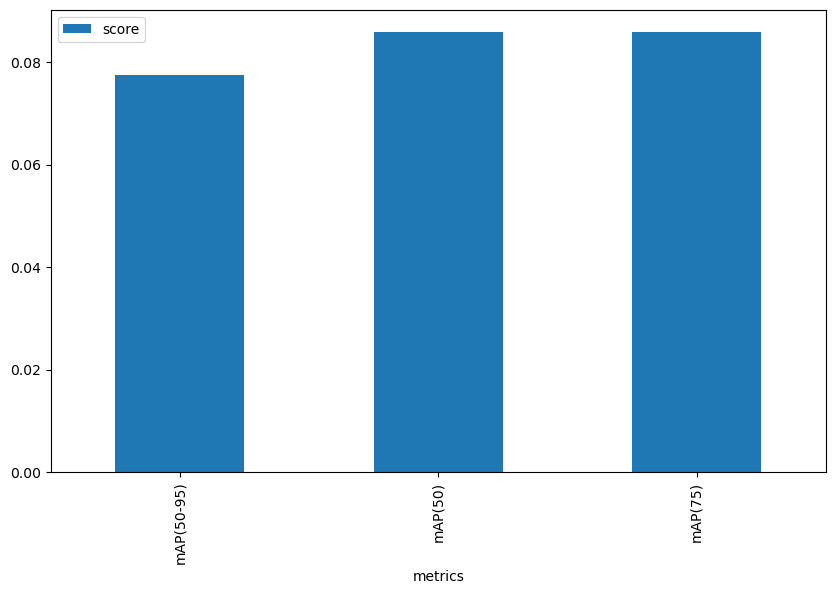

In [26]:
eval_df.plot(kind='bar',x='metrics',y='score')

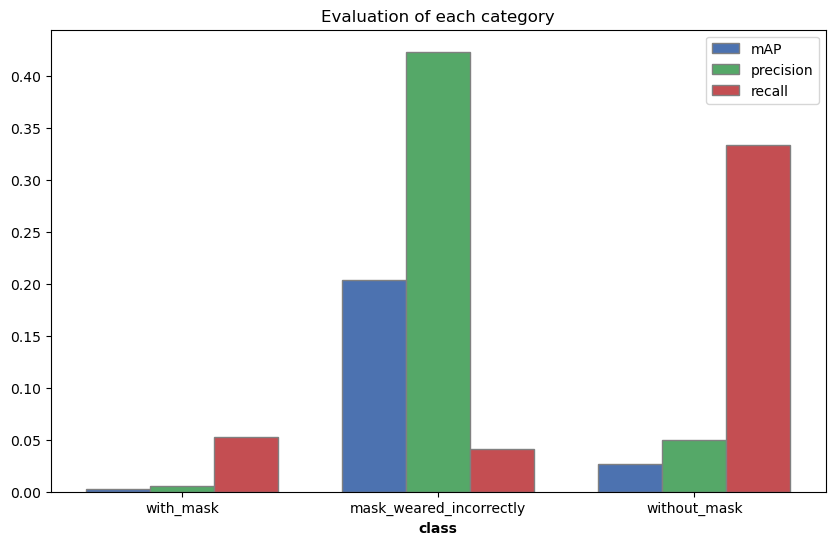

In [27]:
barWidth = 0.25
r1 = np.arange(len(mAP_cls['class']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, mAP_cls['mAP'], color='b', width=barWidth, edgecolor='grey', label='mAP')
plt.bar(r2, mAP_cls['precision'], color='g', width=barWidth, edgecolor='grey', label='precision')
plt.bar(r3, mAP_cls['recall'], color='r', width=barWidth, edgecolor='grey', label='recall')
plt.xlabel('class', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(mAP_cls['class']))], mAP_cls['class'])
plt.legend()
plt.title("Evaluation of each category")
plt.show()

# Inference

In [28]:
import cv2
from time import sleep

In [29]:
def get_boxed_img(img, result, conf_thres=0.65):
    """
    Returns image with bounding boxes.
    
    Args:
        img : Image on which to draw bounding boxes.
        result : Output of YOLO prediction.
        conf_thres : Confidence threshold to follow. default 0.65
    """
    boxes = result.boxes.xyxy.tolist()
    class_ = result.boxes.cls.tolist()
    name = result.names
    confidence = result.boxes.conf.tolist()
    
    for box, cls, cnf in zip(boxes, class_, confidence):
        if cnf < conf_thres:
            continue
        
        color = (0, 0, 0)
        if cls == 0:
            color = (0, 255, 0)  # Green
        elif cls == 2:
            color = (255, 0, 0)  # Red
        else:
            color = (0, 0, 255)  # Blue
        
        x1, y1, x2, y2 = map(int, box)
        
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        text = f"{name[cls]} {cnf:.2f}"
        
        font_scale = max(min((x2 - x1) / 100, (y2 - y1) / 100), 0.5)
        font_thickness = max(int(font_scale * 2), 1)
        
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        text_x = x1 + (x2 - x1) // 2 - text_width // 2
        text_y = max(y1 - 10, text_height + 5)
        
        cv2.rectangle(img, (text_x - 5, text_y - text_height - 5), (text_x + text_width + 5, text_y + 5), color, -1)
        
        cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)
    
    return img


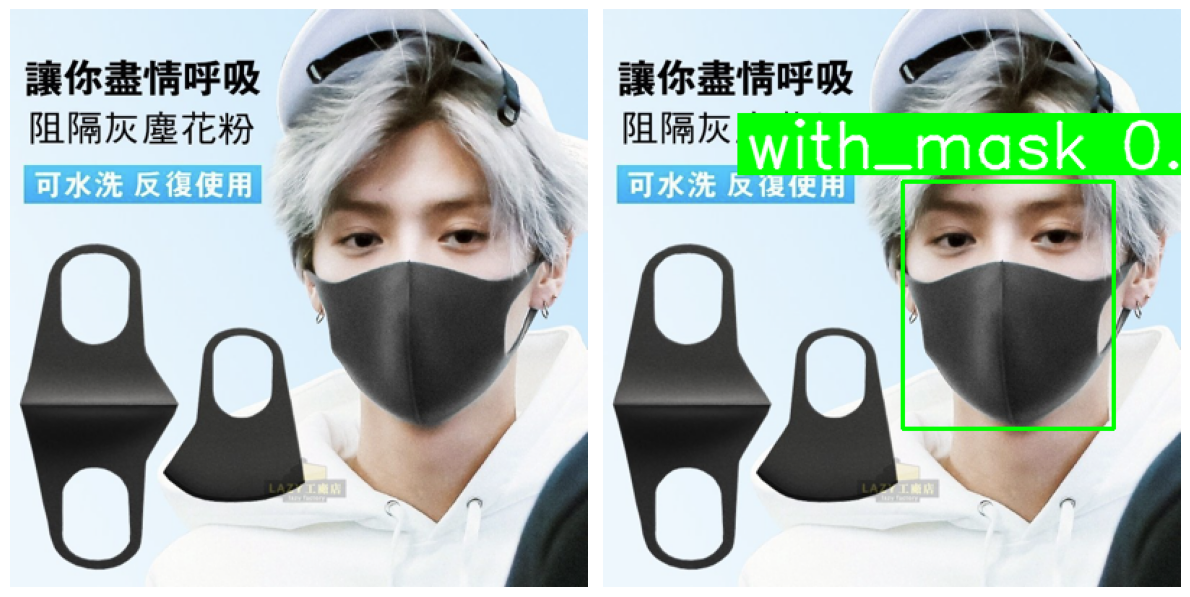

In [30]:
for i in os.listdir('./dataset/images/validation')[:10]:
    clear_output(wait=True)
    path = os.path.join('./dataset/images/validation',i)
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.subplot(1,2,2)
    result = model.predict(path,verbose=False)[0]
    imgp = get_boxed_img(img,result)
    plt.imshow(imgp)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    sleep(2)

In [31]:
# Video parameters
video_file = './outputs/output.webM'
image_save_path = './outputs/temp.jpeg'
frame_rate = 30  
duration_per_image = 2  
height, width, channels = 800, 800, 3
bit_rate = 5000

try:
    fourcc = cv2.VideoWriter_fourcc(*"VP90")
    writer = cv2.VideoWriter(video_file, fourcc, frame_rate, (width, height))
    writer.set(cv2.VIDEOWRITER_PROP_QUALITY,bit_rate)
    assert writer.isOpened()
    print("Supported")
except:
    print("Not supported")

# Loop through images and write plots to video
image_folder = './dataset/images/validation'
for i in os.listdir(image_folder):
    clear_output(wait=True)
    path = os.path.join(image_folder, i)
    
    plt.figure(figsize=(width//100, height//100))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    
    # Plot processed image
    plt.subplot(1, 2, 2)
    result = model.predict(path, verbose=False)[0]
    imgp = get_boxed_img(img, result)
    plt.imshow(imgp)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(image_save_path,format='jpeg')
    plt.close()
    
    img = cv2.imread(image_save_path)
    
    # Write the same frame for the duration
    for _ in range(frame_rate * duration_per_image):
        writer.write(img)

writer.release()
os.remove(image_save_path)
print(f"Video saved successfully: {video_file}")

Video saved successfully: ./outputs/output.webM


# Results
The trained YOLOv8 model achieved significant accuracy in detecting faces and classifying mask-wearing behavior. It demonstrates robust performance in real-time scenarios, making it suitable for applications in public safety and health monitoring.

# Conclusion
Face mask detection using YOLOv8 presents a reliable solution for automating mask compliance monitoring in public spaces. The model's ability to classify mask-wearing behavior with high accuracy contributes to enhancing safety protocols in various environments.